In [1]:
from simulate import HawkesProcess, PriceProcess, MultiHawkesProcess
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

In [53]:
mu, alpha, beta = 0.16, 0.024, 0.11
T = 500
pp = PriceProcess(mu, alpha, beta)
ts = pp.simulate(T)
ts.index = pd.to_datetime(ts.index, unit='s') # ts set index to be datetime in seconds

In [56]:
final = []
for _ in range(100):
    ts = pp.simulate(T)
    final.append(ts.iloc[-1])

In [57]:
sum(final)/len(final)

5.3

In [9]:
# mus = [0.16, 0.16]
# alphas = [[0.024, 0.024], [0.024, 0.024]]
# betas = [[0.11, 0.11], [0.11, 0.11]]

# hawkes = MultiHawkesProcess(mus, alphas, betas)
# ts = hawkes.simulate(T)
# hawkes.get_rate(0, ts, 400)

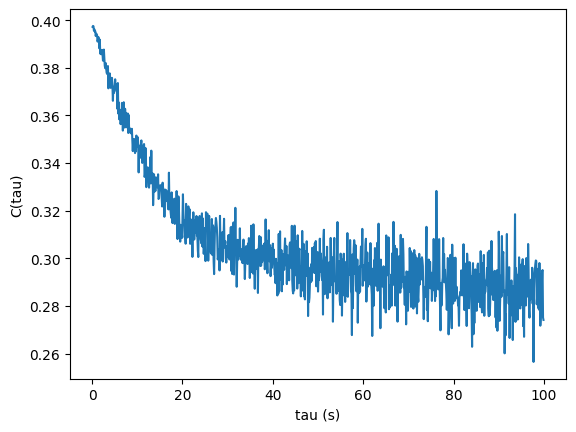

In [21]:
def C(ts: pd.Series, tau: pd.Timedelta):
    # resample the series to have a constant time step
    T = ts.index[-1] - ts.index[0]
    ts = ts.resample(rule=tau).first().ffill()
    qv = ((ts.diff())**2).sum() / T.total_seconds()
    return qv

taus = pd.to_timedelta(range(100,100000,100), unit='ms')

C_values = [C(ts, tau) for tau in taus]
plt.plot(taus.total_seconds(), C_values)
plt.xlabel('tau (s)')
plt.ylabel('C(tau)')
plt.show()

In [11]:
def C_func(theta):
    mu, alpha, beta = theta
    Lambda = 2*mu / (1 - alpha/beta)
    kappa = 1 / (1 + alpha/beta)
    gamma = alpha + beta

    def C(tau):
        return Lambda * ( kappa**2 + (1-kappa**2)*(1-np.exp(-gamma*tau))/(gamma*tau))
    
    return C

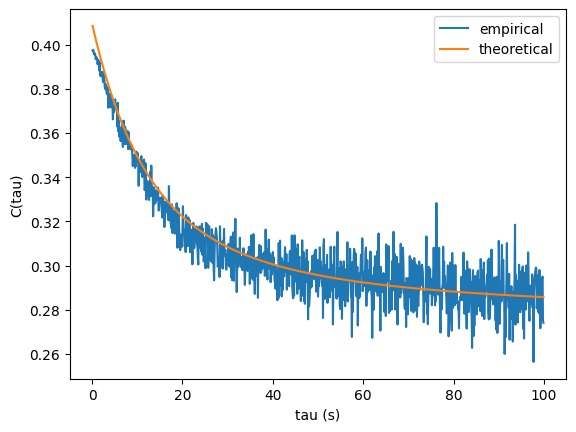

In [22]:
C_th = C_func([mu, alpha, beta])
C_values_th = [C_th(tau.total_seconds()) for tau in taus]
plt.plot(taus.total_seconds(), C_values, label='empirical')
plt.plot(taus.total_seconds(), C_values_th, label='theoretical')
plt.xlabel('tau (s)')   
plt.ylabel('C(tau)')
plt.legend()
plt.show()

## Playing with multihawx

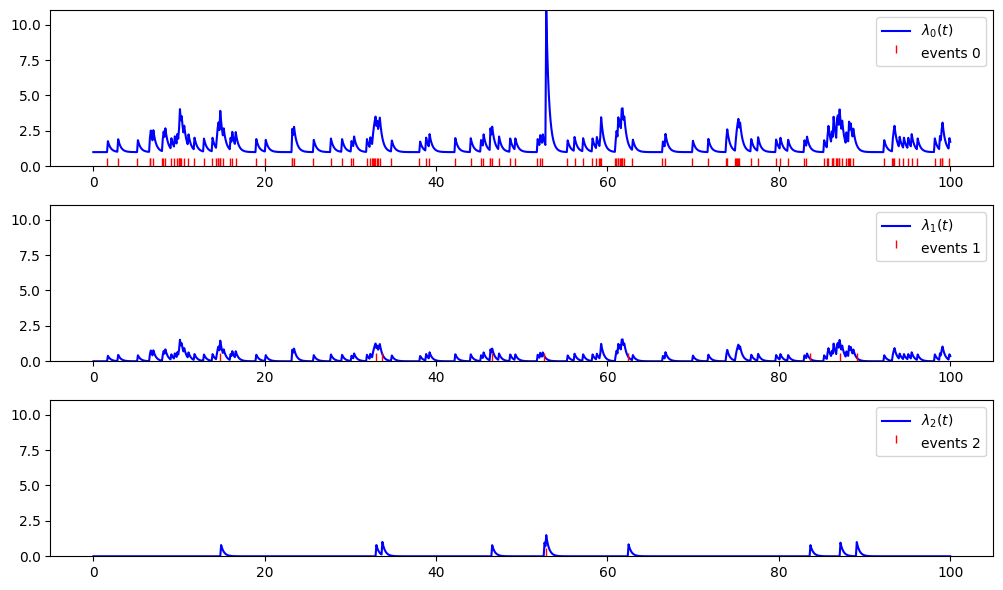

In [30]:
mus = [1, 0, 0]
alphas = [[1, 0, 10], [0.5, 0, 0], [0, 1, 1]]
betas = [[3, 3, 3], [3, 3, 3], [3, 3, 3]]

hawkes = MultiHawkesProcess(mus, alphas, betas)
T = 100
events = hawkes.simulate(T)
hawkes.plot(events, T)

## QQ plot to perform KS residuals test to make sure my univariate hawx algo is correct

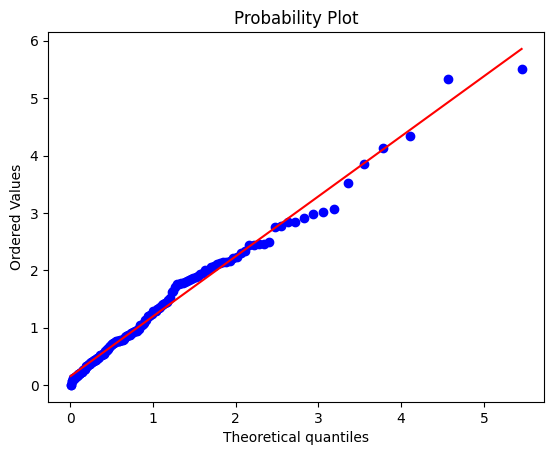

In [156]:
mu, alpha, beta = 1.6, 2.4, 11
hwk = HawkesProcess(mu, alpha, beta)
T = 100
events = hwk.simulate(T)

hwk.plot_QQ(events)

In [136]:
# retrieve the actual EURUSD tick data

# df = pd.read_csv("../../datasets/TrueFX/EURUSD-2024-02/EURUSD-2024-02.csv", header=None)
# df.columns = ['Pair', 'TimeStamp', 'Bid', 'Ask']
# df = df[['TimeStamp', 'Bid', 'Ask']]
# df['TimeStamp'] = pd.to_datetime(df['TimeStamp']) - pd.Timedelta(hours=5) # turn GMT to EST time
# df['Date'] = df['TimeStamp'].dt.date

# chosen_date = pd.to_datetime('2024-02-01').date()
# sub_df = df[df['Date'] == chosen_date]
# sub_df
# copy_sub_df = sub_df.copy()